In [1]:
import torch##
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import platform
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

In [2]:
home_directory = os.path.expanduser('~')
system_type = platform.system()

# デフォルトの OneDrive フォルダ名
onedrive_path = None
if system_type == "Windows":
    # Windows では環境変数が使える（MS公式な方法）
    onedrive_path = os.environ.get("OneDrive")
    if onedrive_path is None:
        # フォールバック
        onedrive_path = os.path.join(home_directory, "OneDrive")
elif system_type == "Darwin": 
    onedrive_path = os.path.join(home_directory, "Library", "CloudStorage", "OneDrive-個人用(2)")

print(f"OneDrive path: {onedrive_path}")


OneDrive path: /Users/konishi/Library/CloudStorage/OneDrive-個人用(2)


In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)


In [4]:
def get_new_dataloader(mnist_train,mnist_test,batch_size=64):

    train_dataloader = DataLoader(mnist_train,batch_size,shuffle=True)
    test_dataloader = DataLoader(mnist_test,batch_size,shuffle=False)
    return train_dataloader, test_dataloader

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [6]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size) #(b,p,k,k)

    return kernels

In [7]:
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        kernel_in = kernel_size ** 2 * channels
        output_dim = int(kernel_in/leverage)
        phase = torch.rand(output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, kernel_in)/ np.sqrt(kernel_in)
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)
        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False
        self.alpha = torch.rand(kernel_in) * 0.5 + 0.5  #<<<<<<<<<<<<<<<<<
        self.alpha = self.alpha.detach().to(device)#<<<<<<<<<<<<<<<<<<<<<<
        self.alpha.requires_grad = False#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    def forward(self, x):
        b, n_patches,  k, _ = x.shape
        x = x.reshape(b*n_patches, -1)
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T 
        x = torch.abs(x)**2 
        return x

In [8]:
class MLP(nn.Module):
    def __init__(self,potential_dim):
        super(MLP, self).__init__()
        mid_num = int(potential_dim/2)
        self.fc1 = nn.Linear(potential_dim, mid_num) 
        self.fc2 = nn.Linear(mid_num, 10)
        self.func = nn.ReLU()

    def forward(self, x):
        x = self.func(self.fc1(x))  # 隠れ層
        x = self.fc2(x)  # 出力層
        return x

In [9]:
class EncoderClassifier(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage):
        super(EncoderClassifier, self).__init__()

        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        
        kernel_in = channels*kernel_size**2
        feat_dim = int(kernel_in/leverage)
        num_patches = (28//kernel_size)*(28//kernel_size)
        potential_dim = num_patches * feat_dim
        self.split = split_into_kernels
        self.encoder = Encoder(kernel_size,leverage,channels) 
        self.bn = nn.BatchNorm1d(feat_dim)#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        self.classifier =  MLP(potential_dim)
        
    def forward(self, x):
        b=x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)  
        x = self.split(x, self.kernel_size)
        x = self.encoder(x) 
        x = self.bn(x)#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        x = x.reshape(b, -1)
        x = self.classifier(x)
        return x

1/5th Time Epoch: 10/10

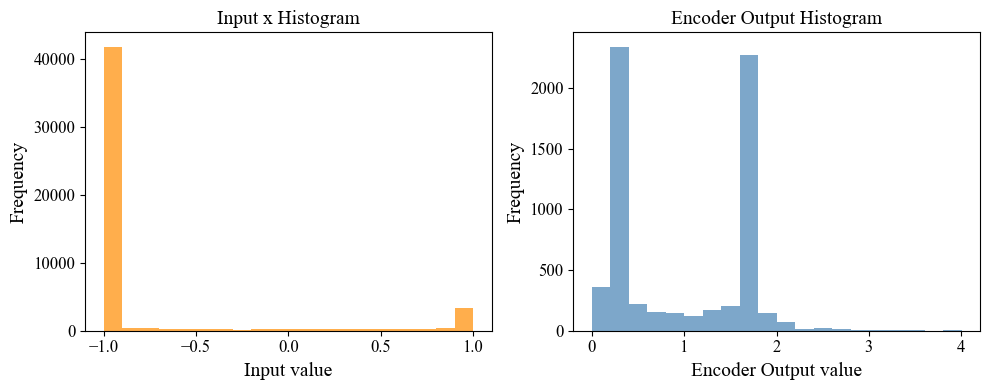

Test Accuracy: 86.88%
loss_train: 0.3971,loss_test: 0.4250
LOSS:0.4250
ProcessingTime: 53.984975814819336


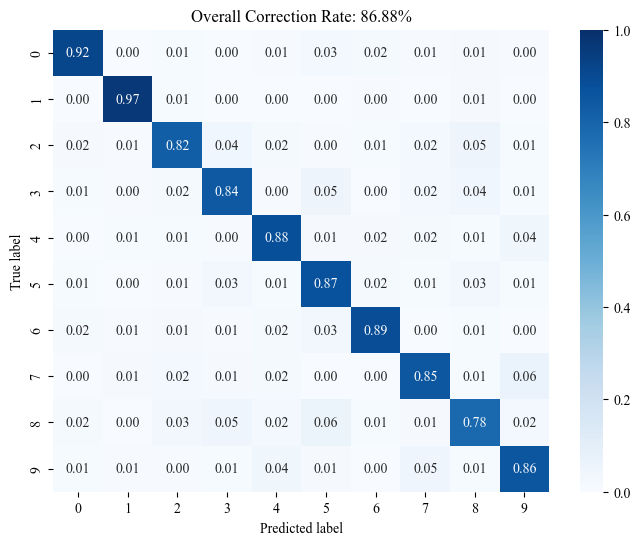

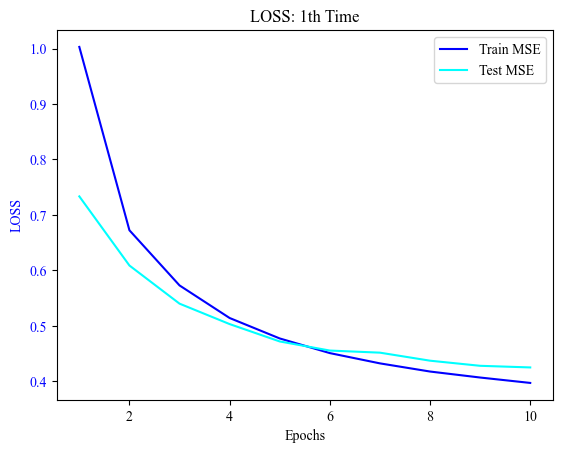

2/5th Time Epoch: 10/10

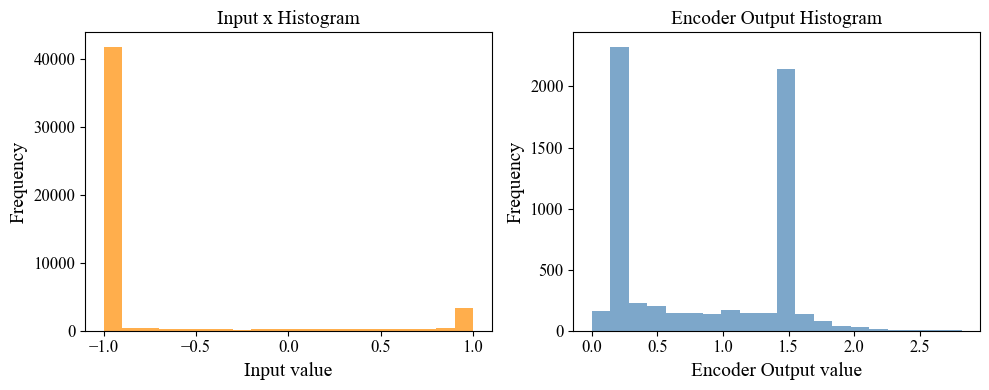

Test Accuracy: 89.01%
loss_train: 0.3182,loss_test: 0.3465
LOSS:0.3465
ProcessingTime: 53.91357398033142


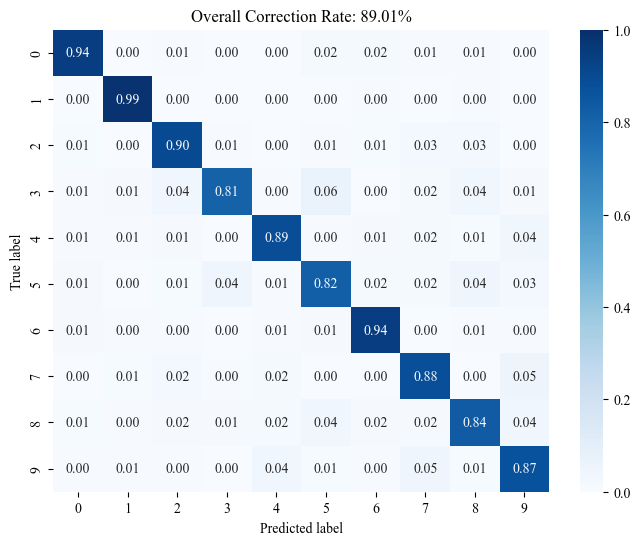

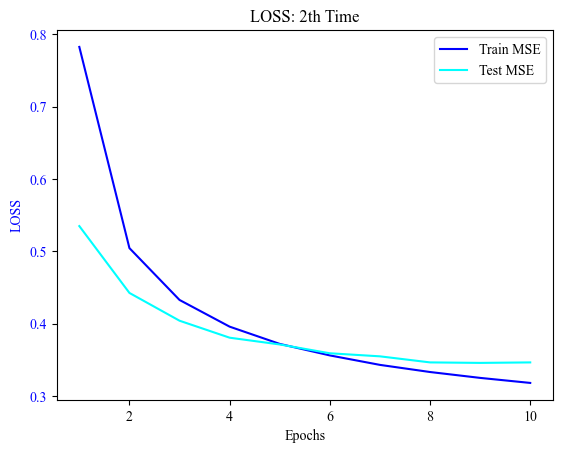

3/5th Time Epoch: 10/10

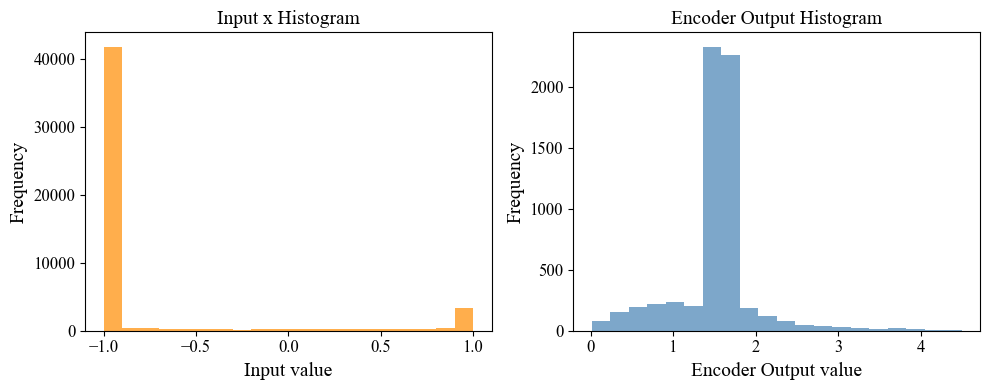

Test Accuracy: 90.84%
loss_train: 0.2662,loss_test: 0.3082
LOSS:0.3082
ProcessingTime: 53.61238718032837


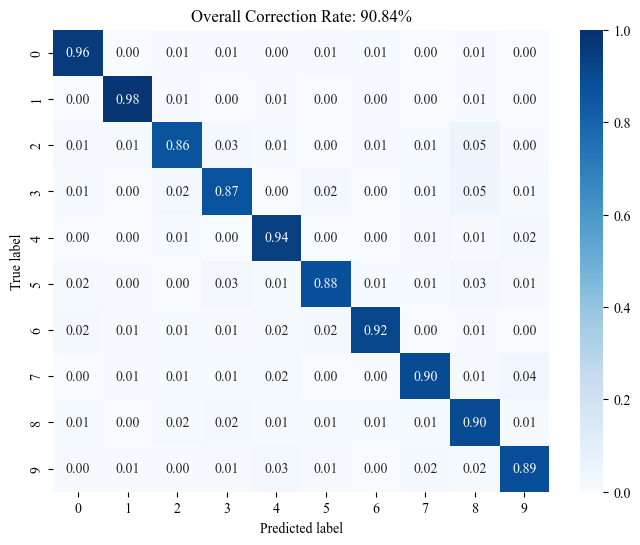

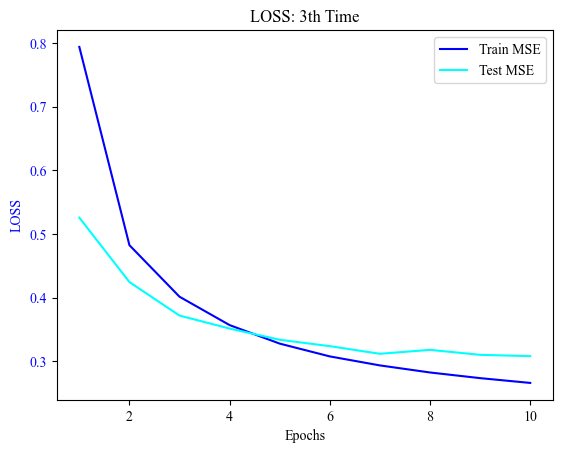

4/5th Time Epoch: 10/10

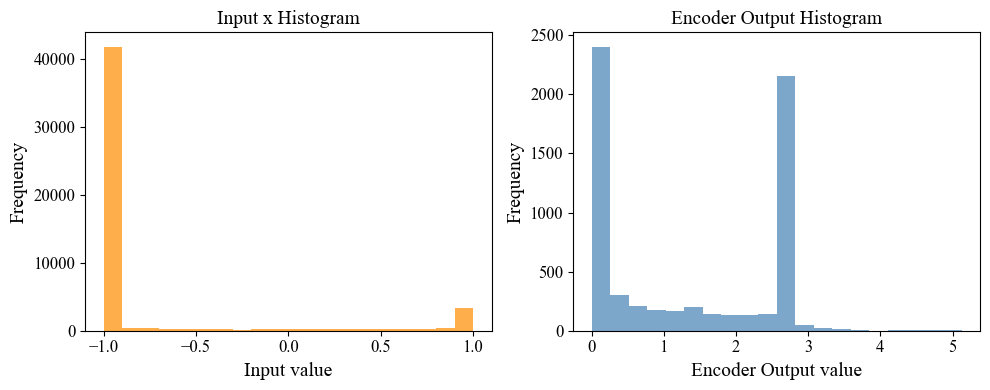

Test Accuracy: 86.98%
loss_train: 0.3847,loss_test: 0.4018
LOSS:0.4018
ProcessingTime: 52.4424946308136


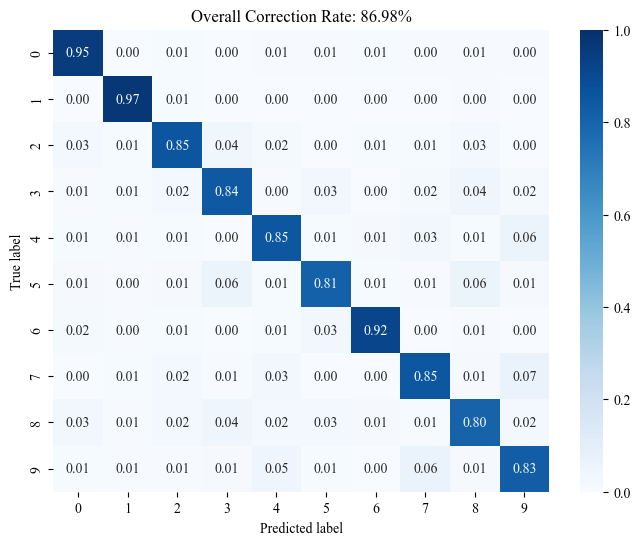

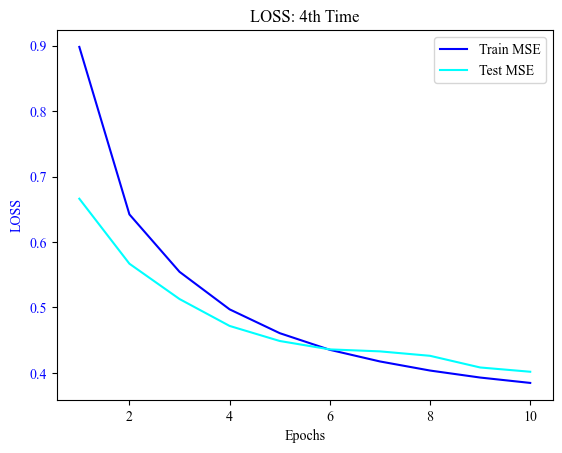

5/5th Time Epoch: 10/10

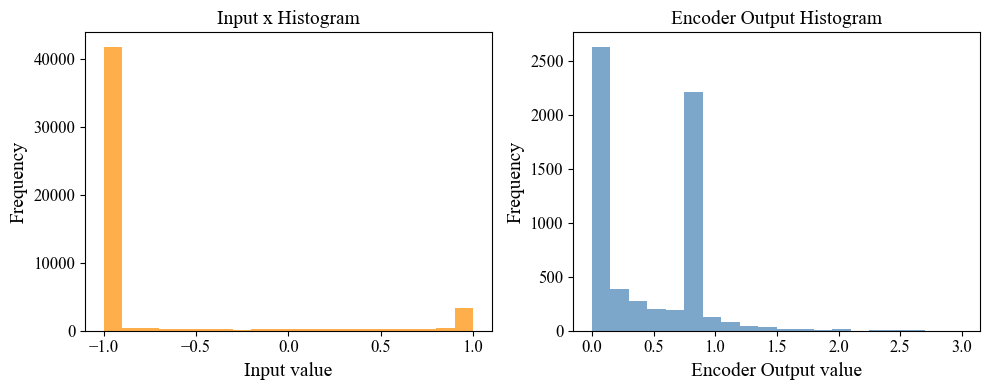

Test Accuracy: 88.89%
loss_train: 0.3248,loss_test: 0.3505
LOSS:0.3505
ProcessingTime: 53.13874959945679


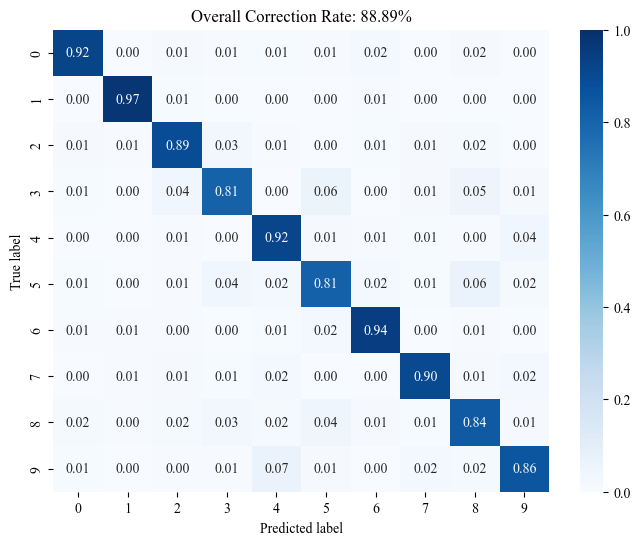

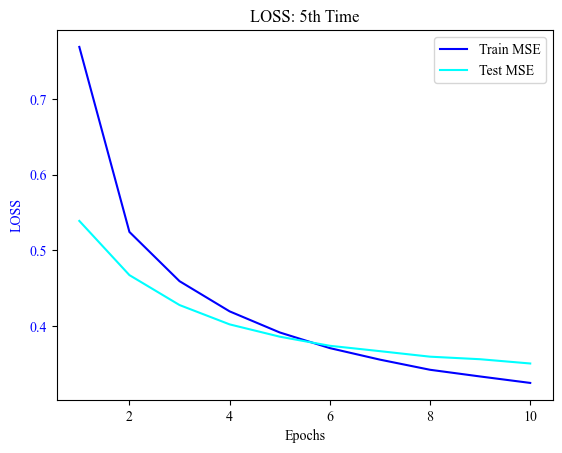

In [ ]:
channels = 1
img_size = 28
leverage = 8
kernel_size = 4
batch_size = 64
max_epochs = 10##10

num_try = 5##5

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_acc = []

for num_times in range(num_try): 

    model = EncoderClassifier(img_size,channels, kernel_size, leverage).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_dataloader,test_dataloader = get_new_dataloader(mnist_train,mnist_test,batch_size=64)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)
            loss = criterion(y, t) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        model.eval()
        with torch.no_grad():
            all_preds = []
            all_labels = []
            correct = 0
            total = 0
            first_batch = True
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                _, predicted = torch.max(y, 1)
                loss = criterion(y,t)
                loss_test += loss.item()        
                total += t.size(0)
                correct += (predicted == t).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(t.cpu().numpy())
                if epoch == max_epochs - 1:
                    if first_batch:
                        x = x.view(batch_size, channels, img_size, img_size)  
                        x_splitted = model.split(x, kernel_size)
                        x_in_flat = x_splitted.reshape(-1).detach().cpu().numpy()
                        x_encoded = model.encoder(x_splitted)
                        x_out_flat = x_encoded.reshape(-1).detach().cpu().numpy()

                        # サブプロットで横に並べて表示
                        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

                        # 入力ヒストグラム
                        axes[0].hist(x_in_flat, bins=20, color='darkorange', alpha=0.7)
                        axes[0].set_xlabel("Input value", fontsize=14)
                        axes[0].set_ylabel("Frequency", fontsize=14)
                        axes[0].set_title("Input x Histogram", fontsize=14)
                        axes[0].tick_params(labelsize=12)
                        axes[0].set_ylim(0,)

                        # エンコーダ出力ヒストグラム
                        axes[1].hist(x_out_flat, bins=20, color='steelblue', alpha=0.7)
                        axes[1].set_xlabel("Encoder Output value", fontsize=14)
                        axes[1].set_ylabel("Frequency", fontsize=14)
                        axes[1].set_title("Encoder Output Histogram", fontsize=14)
                        axes[1].tick_params(labelsize=12)

                        plt.tight_layout()
                        plt.show()

                        first_batch = False

        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        #if epoch == max_epochs-1:
    All_loss_test.append(loss_test_)
    All_pro_time.append(sum(pro_time_)) 

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    Test_acc = 100 * correct / total
    All_test_acc.append(Test_acc)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print(f"LOSS:{Last_loss_test:.4f}")
    print('ProcessingTime:',sum(pro_time_))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(10), yticklabels=range(10),vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Overall Correction Rate: {100 * correct / total:.2f}%")
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'LOSS: %dth Time'%(num_times+1) #
    plt.title(title)
    plt.show()


In [18]:
import pandas as pd
ACC_mean = np.mean(All_test_acc)
ACC_best = np.max(All_test_acc)
ACC_bestID = np.argmax(All_test_acc) + 1
ACC_worst = np.min(All_test_acc)
ACC_worstID = np.argmin(All_test_acc) + 1

LOSS_mean = np.mean(All_last_loss)
LOSS_best = np.min(All_last_loss)
LOSS_bestID = np.argmin(All_last_loss) + 1
LOSS_worst = np.max(All_last_loss)
LOSS_worstID = np.argmax(All_last_loss) + 1

PRO_mean = np.mean(All_pro_time)
PRO_best = np.min(All_pro_time)  # 最短
PRO_bestID = np.argmin(All_pro_time) + 1
PRO_worst = np.max(All_pro_time) # 最長
PRO_worstID = np.argmax(All_pro_time) + 1

data = {
    "": ["ACC", "LOSS", "TIME"],
    "Average": [ACC_mean, LOSS_mean, PRO_mean],
    "Best ID": [ACC_bestID, LOSS_bestID, PRO_bestID],
    "Best": [ACC_best, LOSS_best, PRO_best],
    "Worst ID": [ACC_worstID, LOSS_worstID, PRO_worstID],
    "Worst": [ACC_worst, LOSS_worst, PRO_worst],
}
df = pd.DataFrame(data)
print(df)

           Average  Best ID       Best  Worst ID      Worst
0   ACC  88.520000        3  90.840000         1  86.880000
1  LOSS   0.366414        3   0.308246         1   0.425013
2  TIME  53.418436        4  52.442495         1  53.984976


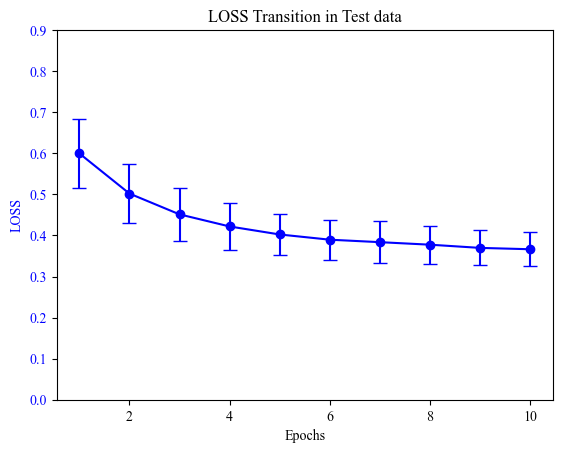

In [ ]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('LOSS Transition in Test data')
plt.ylim(0,0.9)
plt.show()


In [13]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','MNIST_texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MLP_PM_Class01_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

/Users/konishi/Library/CloudStorage/OneDrive-個人用(2)/CODES/konishi_Classifer/data/MNIST_texts
